In [1]:
from typing import Tuple

In [1]:
import torch
from torch_geometric.data import InMemoryDataset, Data, Batch
from torch.utils.data import DataLoader, Subset
from sklearn.calibration import LabelEncoder
import json 

c:\Users\Abderrahmane\ProjectsC\ReconnaissanceAlgebrique\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [254]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

Constants

In [255]:
GENERATED_DATASET_SIZE = 300
BATCH_SIZE = 32
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2

In [256]:

def dict_to_geometric_representation(in_graph_dict: dict, encoder) -> Data:
    node_list = []
    edge_mappings = []
    def traverse_graph(graph = in_graph_dict):
        nonlocal node_list
        nonlocal edge_mappings
        curr_node_index = len(node_list)
        encoded_data = encoder({"type": graph["type"], "subtype": graph["subtype"], "value": graph["value"]})
        # print("Encoded data: ", encoded_data)
        node_list.append(encoded_data)
        if "children" in graph.keys():
            for child in graph["children"]:
                edge_mappings.append((curr_node_index, traverse_graph(child)) ) #I'm retarded.
        return curr_node_index
    traverse_graph()
    nodes = torch.tensor(node_list,dtype=torch.float32)
    edges = torch.tensor([[x[0] for x in edge_mappings], [x[1] for x in edge_mappings]], dtype=torch.long) # Probably slow and mentally degenerated
    geom_data = Data(x=nodes, edge_index=edges)
    return geom_data

In [257]:
TYPES = ["FUNC", "OPERATION", "POW", "LITERAL", "VARIABLE", "CONSTANT_LITERAL"]
OPERATIONS = ["ADD", "MUL", "FUNC", "POW"]
FUNCTIONS = ["SIN", "COS", "TAN", "EXP", "LOG", "SINH", "COSH"]
VARIABLE_ALPHABET = [chr(x) for x in range(ord('a'), ord('z')+1) if chr(x) not in ["e", "i"]]
CLASSIC_CONSTANTS = ["PI", "I", "g","e", "zoo"]


In [346]:

import math

nan_count = 0 
sample_count = 0
def make_node_attribute_encoder(label_encoder:LabelEncoder, rep = 4):
    def node_attr_encoder(attr):
        global nan_count
        global sample_count
        type_encoding = label_encoder.transform([attr["type"]]) if attr["type"] else [-1]
        subtype_encoding = label_encoder.transform([attr["subtype"]]) if attr["subtype"] else [-1]
        value_encoding_vec = None
        if attr["value"]:
            if isinstance(attr["value"], str):
                value_encoding = label_encoder.transform([attr["value"]])
                value_encoding_vec = [(0 if i % 2 == 0 else value_encoding[0]) for i in range(rep)]
            else: 
                # big num correction: 
                sample_count += 1
                val = float(attr["value"])
                print(val)
                if abs(val) > 100000:
                    val /= 1000
                elif math.isnan(val):
                    val = 0
                    nan_count += 1
                value_encoding_vec = [(0 if i % 2 == 1 else val) for i in range(rep)]
                
        else:
            value_encoding = [-1]
            value_encoding_vec = value_encoding*rep 
        
        type_encoding_vec = [type_encoding[0]] * rep
        subtype_encoding_vec = [subtype_encoding[0]] * rep       
        
        return type_encoding_vec + subtype_encoding_vec + value_encoding_vec
        # if isinstance(attr, str) and attr in OPERATIONS+FUNCTIONS+CLASSIC_CONSTANTS+VARIABLE_ALPHABET:
        #     res = label_encoder.transform([attr])
        #     return [res[0]]*(rep + 1)
        # else:
        #     return [0] + [float(attr)]*rep
        
            
    return node_attr_encoder

In [347]:
def create_dataset_class(expression):
    # Will it be the same for both datasets ? 
    le = LabelEncoder()
    le.fit(OPERATIONS+FUNCTIONS+CLASSIC_CONSTANTS+VARIABLE_ALPHABET+TYPES)
    class MathExpressionDataset(InMemoryDataset):
        def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
            super().__init__(root, transform, pre_transform, pre_filter, force_reload=True)
            self.load(self.processed_paths[0])
            
        @property
        def raw_file_names(self):
            return ['math_datagen.json']

        @property
        def processed_file_names(self):
            return ['data.pt']
        

        def process(self):
            # Read data into huge `Data` list.
            data_list = []
            for file in self.raw_file_names:
                with open(file) as file_handle:
                    object_data = json.load(file_handle)
                    for comparison in object_data:
                        # print("Comparison before : ",comparison)
                        # LEGACY : Remove first case once fixed bug in datagen
                        if isinstance(comparison,list):
                            expr = comparison[0 if expression == "expr_l" else 1]
                            score = comparison[2]
                            geometric_expr = dict_to_geometric_representation(expr, make_node_attribute_encoder(le))
                            geometric_expr.y = score #torch.tensor([score],dtype=torch.float32)
                            data_list.append(geometric_expr)
                        else:
                            expr = comparison[expression]
                            score = comparison["score"]
                            geometric_expr = dict_to_geometric_representation(expr, make_node_attribute_encoder(le))
                            geometric_expr.y = score #torch.tensor([score],dtype=torch.float32)
                            data_list.append(geometric_expr)
                        
            if self.pre_filter is not None:
                data_list = [data for data in data_list if self.pre_filter(data)]

            if self.pre_transform is not None:
                data_list = [self.pre_transform(data) for data in data_list]
            self.save(data_list, self.processed_paths[0])
    return MathExpressionDataset
    

In [348]:
class ExpressionPairDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform=None, pre_transform=None, pre_filter=None):
        super().__init__()
        self.dataset_l = create_dataset_class("expr_l")(root+"_l",transform=None, pre_transform=None, pre_filter=None)
        self.dataset_r = create_dataset_class("expr_r")(root+"_r",transform=None, pre_transform=None, pre_filter=None)
        
    @property 
    def num_features(self):
        return self.dataset_l.num_features
    
    def __len__(self):
        return len(self.dataset_l)
        
    
    
    def __getitem__(self, idx):
        return self.dataset_l[idx], self.dataset_r[idx]

In [349]:
#generate_dataset(GENERATED_DATASET_SIZE,"math_datagen.json") #TODO: Switch to orjson, loading this file will take ages as I generate more data
dataset = ExpressionPairDataset(root="/dataset")

Processing...


-0.5
8.0
5.0
-0.5
8.0
5.0
9.095178317957384e-13
-0.5
8.0
5.0
-0.5
8.0
5.0
-0.5
8.0
5.0
-9.5
9.0
-9.5
9.0
-5.5
2.0
9.5
2.5
4.0
-5.5
2.0
9.5
2.5
4.0
158.3510457461916
92.88823754497841
-5.5
2.0
9.5
2.5
4.0
-1.5
-5.0
3.0
3.5
-10.0
-1.5
-5.0
3.0
3.5
-10.0
1.5
5.0
-3.0
-3.5
10.0
1.5
5.0
-3.0
-3.5
10.0
9.5
9.5
-1.2353591701822895
9.5
-9.5
7.5
0.5
0.5
-5.0
-5.0
0.8414587197941324
-5.0
-4.5
-4.5
-5.0
-5.0
3.0
7.0
0.5
3.0
7.0
0.5
46.76537180435969
3.0
7.0
0.5
3.0
7.0
0.5
-3.0
-7.0
-0.5
-5.5
-0.5
-8.0
-5.5
-0.5
-8.0
6.0
6.0
6.0
6.0
-4.5
8.5
-8.5
-8.5
-3.5
-7.0
7.5
-3.5
-7.0
7.5
-7.0
7.5
-3.5
-3.5
-7.0
7.5
-3.5
-7.0
7.5
3.5
7.0
-7.5
6.0
1.5
3.5
6.0
1.5
3.5
3.0
3.0
7.5
-9.0
7.5
-9.0
0.00021561852686345854
7.5
-9.0
-10.0
1.5
-5.0
-6.0
-5.0
-6.0
-5.0
-6.0
-8.0
-3.5
-8.0
-8.0
-3.5
-8.0
1.0
-8.0
-3.5
-8.0
8.0
3.5
8.0
7.0
2.0
-7.5
7.0
2.0
-7.5
7.0
2.0
-7.5
-7.0
-4.5
9.5
-7.0
-4.5
9.5
7.4483282251505255e-37
-1.0
9.5
-7.0
-4.5
9.5
7.0
4.5
-9.5
-6.0
5.0
-3.0
2.5
-10.0
0.5
2.5
-10.0
0.5
-9.5
1.0
-7.5
-9.5


Done!
Processing...


9.095178317957384e-13
9.095178317957384e-13
9.095178317957384e-13
-0.5
8.0
5.0
-0.5
8.0
5.0
-0.5
8.0
5.0
-9.5
9.0
-9.0
-2.0
8.5
-2.5
-8.5
158.3510457461916
92.88823754497841
158.3510457461916
92.88823754497841
158.3510457461916
92.88823754497841
-5.5
2.0
9.5
2.5
4.0
-1.5
-5.0
3.0
3.5
-10.0
-1.5
-5.0
3.0
3.5
-10.0
1.5
5.0
-3.0
-3.5
10.0
5.5
8.5
-3.0
5.5
-1.2353591701822895
-1.2353591701822895
-1.2353591701822895
9.5
-9.5
7.5
0.5
-6.0
-1.0
-8.0
-5.5
2.5
-5.5
7.0
0.8414587197941324
0.8414587197941324
0.8414587197941324
-5.0
-4.5
-4.5
-5.0
46.76537180435969
46.76537180435969
46.76537180435969
3.0
7.0
0.5
3.0
7.0
0.5
-3.0
-7.0
-0.5
-5.5
-0.5
-8.0
0.5
9.0
9.0
6.0
6.0
6.0
6.0
-4.5
8.5
-8.5
-7.0
7.5
-3.5
-7.0
7.5
-3.5
-7.0
7.5
-3.5
-3.5
-7.0
7.5
-3.5
-7.0
7.5
3.5
7.0
-7.5
6.0
1.5
3.5
-3.5
-9.0
-4.0
3.0
8.0
-1.0
3.0
0.00021561852686345854
0.00021561852686345854
0.00021561852686345854
7.5
-9.0
-10.0
1.5
-5.0
-6.0
-5.0
-6.0
1.5
7.5
1.0
1.0
1.0
-8.0
-3.5
-8.0
8.0
3.5
8.0
7.0
2.0
-7.5
7.0
2.0
-7.5


Done!


In [350]:
print(len(dataset))

8000


In [351]:
print("nan_count", nan_count)
print("sample_count: ", sample_count)

nan_count 8
sample_count:  32484


In [352]:
from torch import nn
from torch.nn import Linear, ReLU, LeakyReLU, init
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
import torch.optim.lr_scheduler as lr_scheduler


In [353]:
class FormulaNet(nn.Module):
    def __init__(self, hidden_channels: int, embedding_space: int):
        super(FormulaNet, self).__init__()
        self.dense_1 = Linear(dataset.num_features, dataset.num_features*2) 
        self.dense_2 = Linear(dataset.num_features*2, dataset.num_features*2) 
        
        self.relu_1 = LeakyReLU(0.1)
        self.gconv_1 = GCNConv(dataset.num_features*2, hidden_channels)
        self.gconv_2 = GCNConv(hidden_channels, hidden_channels)
        self.dense_3 = Linear(hidden_channels, embedding_space)
        gain = torch.nn.init.calculate_gain("leaky_relu", 0.1)
        # Initialize dense_1 weights
        init.xavier_uniform_(self.dense_1.weight, gain=gain)
        init.xavier_uniform_(self.dense_2.weight, gain=gain)
        # # Initialize gconv_1 weights
        init.xavier_uniform_(self.gconv_1.lin.weight.data.T, gain=gain)
        # # Initialize gconv_2 weights
        init.xavier_uniform_(self.gconv_2.lin.weight.data.T, gain=gain)
        #Initialize dense_3 weights
        init.xavier_uniform_(self.dense_3.weight, gain=gain)
    
    def forward(self, x, edge_index, batch):
        
        nan_mask = torch.isnan(x)
        # if nan_mask.any():
        #     print("Some values of the input are nan: ", x[nan_mask])
        #     # Replace NaNs with 0s
        #     x[nan_mask] = -11
            
        
        # print("X = ", str(x))
        x = self.dense_1(x)
        # print("d1 X = ", str(x))
        x = self.relu_1(x)
        
        x = self.dense_2(x)
        x = self.relu_1(x)

        # #print("rd1 X = ", str(x))
        x = self.gconv_1(x, edge_index)
        # print("gcn1 X = ", str(x))
        x = self.relu_1(x)
        # print("rgcn1 X = ", str(x))
        # x = self.gconv_2(x, edge_index)
        # # print("gcn2 X = ", str(x))
        # x = self.relu_1(x)
        # # print("rgcn2 X = ", str(x))
        x = global_mean_pool(x, batch)
        x = F.dropout(x, p=0.4,training=self.training)
        x = self.dense_3(x)
        x = self.relu_1(x)
        # nan_mask = torch.isnan(x)
        # if nan_mask.any():
        #     print("Some values of the input are nan: ", x[nan_mask])
            
        return x
    

In [354]:
class SiameseFormulaNet(nn.Module):
    def __init__(self, hidden_channels, embedding_space):
        super(SiameseFormulaNet, self).__init__()
        self.formulanet = FormulaNet(hidden_channels, embedding_space)
        # self.fc = nn.Sequential(
        #     Linear(embedding_space*2, embedding_space),
        #     ReLU(inplace=True),
        #     Linear(embedding_space, 1)
        # )
        # self.sigmoid = nn.Sigmoid() # TODO: Only used it for testing purposes, everything is subject to change Okay
    

    def forward(self, expr_l, expr_r):
        # print(expr_l)
        # print("X = ", expr_l.x)
        # print("X shape = ", expr_l.x.shape)
        # print("Batch = ",expr_l.batch)
        # print("Batch shape = ",expr_l.batch.shape)
        # print("Y =", expr_l.y)
        # print("Edge index = ",expr_l.edge_index)
        # print("Edge index shape = ",expr_l.edge_index.shape)
        
        embed_l = self.formulanet(expr_l.x,expr_l.edge_index, expr_l.batch)
        # print("Embed Left : ", embed_l)
        # print("Embed Left Shape: ", embed_l.shape)
        # embed_l = embed_l.view(embed_l.size()[0], -1)
        
        
        embed_r = self.formulanet(expr_r.x,expr_r.edge_index, expr_r.batch)
        # print("Embed Right : ", embed_r)
        # print("Embed Right Shape: ", embed_r.shape)
        # embed_r = embed_r.view(embed_r.size()[0], -1)
        
        # output = torch.cat((embed_l, embed_r), 1)
        
        # output = self.fc(output)
        # output = self.sigmoid(output)
        # return output
        return embed_l, embed_r
        
        
        

In [355]:
from torch.utils.data import random_split

In [356]:
total_len = len(dataset.dataset_l)
train_len = int(TRAIN_RATIO * total_len)
val_len = int(VAL_RATIO * total_len)
test_len = total_len - train_len - val_len
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

In [357]:

def collate(data_list):
    batchA = Batch.from_data_list([data[0] for data in data_list])
    batchB = Batch.from_data_list([data[1] for data in data_list])
    return batchA, batchB
# NOTE: Type ignore only for collate_fn_t ... make sure it doesn't get in the way of correct typing for the dataset
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate) # type: ignore
validation_laoder = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle= False, collate_fn = collate)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate) # type: ignore


In [358]:
device = torch.device("cpu") #torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [359]:
model = SiameseFormulaNet(32,32).to(device)

In [360]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00000005)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=0.001, end_factor=0.0005, total_iters=10)

In [361]:
from tqdm import tqdm

In [362]:
training_loss = []  # Store training loss per epoch
validation_loss = []  # Store validation loss per epoch

In [363]:
def contrastive_loss(embed_l, embed_r, labels, margin=1.0, threshold=0.5):
    # print("Embed Left : ", embed_l)
    # print("Embed Left shape: ", embed_l.shape)
    # print("Embed Right : ", embed_r)
    # print("Embed Right shape: ", embed_r.shape)
    euclidean_distance = F.pairwise_distance(embed_l, embed_r)
    # print("Euclidean distance : ", euclidean_distance)
    #labels = (labels > threshold).float()  # Convert labels to 0 or 1
    # print("Labels : ", labels)
    # print("Labels Shape: ", labels.shape)
    loss_contrastive = torch.mean((1 - labels) * torch.pow(euclidean_distance, 2) +
                                  labels * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0), 2))
    # print("Constrastive Loss : ", loss_contrastive)
    return loss_contrastive

In [364]:
def train(epoch):
    model.train()
    epoch_loss = 0
    for batch_l, batch_r in tqdm(train_loader, desc=f'Epoch {epoch}'):
        # print(batch_l)
        # print("x : ",batch_l.x)
        # print("y : ", batch_l.y)
        # print("edge_index : ", batch_l.edge_index)
        
        # break
        batch_l, batch_r = batch_l.to(device), batch_r.to(device)
        optimizer.zero_grad()
        embed_l, embed_r = model(batch_l, batch_r)
        loss = contrastive_loss(embed_l, embed_r, batch_l.y)
        loss.backward()
        writer.add_scalar("Loss/train", loss, epoch)
        
        # Log gradients
        # for name, param in model.formulanet.named_parameters():
        #     if param.grad is not None and param.grad.numel() > 0:
        #         writer.add_histogram(f'{name}.grad', param.grad, epoch)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step(epoch)
        epoch_loss += loss.item()
    training_loss.append(epoch_loss / len(train_loader))  # Store epoch average loss
    # scheduler.step()
    print(f'Epoch {epoch}, Loss: {epoch_loss / len(train_loader)}')

In [365]:
def validate():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_l, batch_r in validation_laoder:
            batch_l, batch_r = batch_l.to(device), batch_r.to(device)
            embed_l, embed_r = model(batch_l, batch_r)
            # euclidean_distance = F.cosine_similarity(embed_l, embed_r)
            # pred = (euclidean_distance < 0.5).float()  # Adjust the threshold as needed
            # correct += (pred == batch_l.y).sum().item()
            test_loss += contrastive_loss(embed_l, embed_r, batch_l.y).item()

    test_loss /= len(test_loader)
    # acc = correct / len(test_dataset)
    # validation_loss.append(acc)  # Store epoch average loss

    print(f'Test Loss: {test_loss}, Accuracy: ---')

In [366]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [367]:
num_epochs = 10

for epoch in range(num_epochs):
    train(epoch)
    validate()

Epoch 0:   0%|          | 0/150 [00:00<?, ?it/s]C:\Users\Abderrahmane\AppData\Roaming\Python\Python311\site-packages\torch\optim\lr_scheduler.py:149: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
Epoch 0: 100%|██████████| 150/150 [00:03<00:00, 43.16it/s]


Epoch 0, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 1: 100%|██████████| 150/150 [00:01<00:00, 79.73it/s]


Epoch 1, Loss: nan
Test Loss: nan, Accuracy: ---


Epoch 2:  96%|█████████▌| 144/150 [00:01<00:00, 75.37it/s]


KeyboardInterrupt: 

In [ ]:
writer.close()

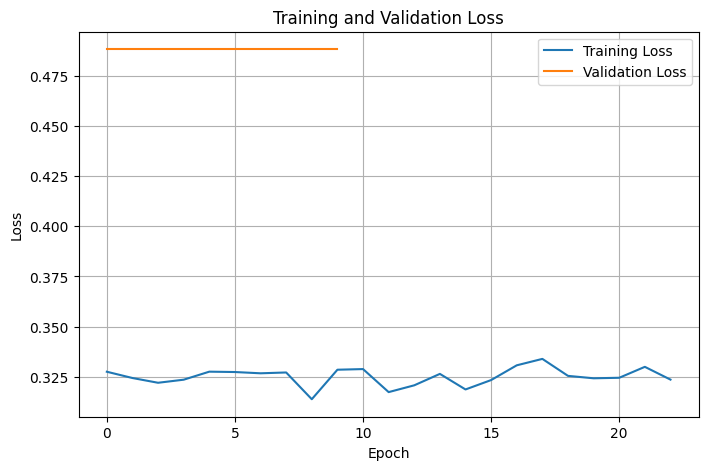

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.grid(True)
plt.legend()
plt.show()


## Evaluation

In [76]:
le = LabelEncoder()
le.fit(OPERATIONS+FUNCTIONS+CLASSIC_CONSTANTS+VARIABLE_ALPHABET+TYPES)
eval_node_attr_encoder = make_node_attribute_encoder(le)

In [77]:
expr_left = {
      "type": "POW",
      "value": None,
      "subtype": None,
      "children": [
        {
          "type": "POW",
          "value": None,
          "subtype": None,
          "children": [
            {
              "type": "LITERAL",
              "value": -3.5,
              "subtype": None,
              "children": []
            },
            {
              "type": "LITERAL",
              "value": 3.0,
              "subtype": None,
              "children": []
            }
          ]
        },
        {
          "type": "LITERAL",
          "value": 4.5,
          "subtype": None,
          "children": []
        }
      ]
    }
expr_right = {
      "type": "POW",
      "value": None,
      "subtype": None,
      "children": [
        {
          "type": "OPERATION",
          "value": None,
          "subtype": "ADD",
          "children": [
            {
              "type": "LITERAL",
              "value": -5.5,
              "subtype": None,
              "children": []
            },
            {
              "type": "LITERAL",
              "value": -10.0,
              "subtype": None,
              "children": []
            }
          ]
        },
        {
          "type": "LITERAL",
          "value": 4.0,
          "subtype": None,
          "children": []
        }
      ]
    }

expr_right_constant_error = {
      "type": "POW",
      "value": None,
      "subtype": None,
      "children": [
        {
          "type": "POW",
          "value": None,
          "subtype": None,
          "children": [
            {
              "type": "LITERAL",
              "value": -5.9,
              "subtype": None,
              "children": []
            },
            {
              "type": "LITERAL",
              "value": -10.0,
              "subtype": None,
              "children": []
            }
          ]
        },
        {
          "type": "LITERAL",
          "value": 4.0,
          "subtype": None,
          "children": []
        }
      ]
    }

In [78]:
expr_l_obj = dict_to_geometric_representation(expr_left, eval_node_attr_encoder)
expr_r_obj = dict_to_geometric_representation(expr_right, eval_node_attr_encoder)
expr_r_c_obj = dict_to_geometric_representation(expr_right_constant_error, eval_node_attr_encoder)

-3.5
3.0
4.5
-5.5
-10.0
4.0
-5.9
-10.0
4.0


In [79]:
y_1 = model(expr_l_obj, expr_r_obj)
y_2 = model(expr_l_obj, expr_l_obj)
y_3 = model(expr_r_obj, expr_r_obj)
y_4 = model(expr_r_obj, expr_r_c_obj)

In [80]:
print(F.cosine_similarity(y_1[0], y_1[1]))
print(F.cosine_similarity(y_2[0], y_2[1]))
print(F.cosine_similarity(y_3[0], y_3[1]))
print(F.cosine_similarity(y_4[0], y_4[1]))


tensor([0.9998], grad_fn=<SumBackward1>)
tensor([1.0000], grad_fn=<SumBackward1>)
tensor([1.], grad_fn=<SumBackward1>)
tensor([1.0000], grad_fn=<SumBackward1>)


In [71]:
# from torchviz import make_dot

# Misc

In [224]:
# make_dot(y_f.mean(), params=dict(formulanet.named_parameters()))